<center><img src="img/logo.png"></center>

<h2> <center> 3 февраля 2021 г.</center> <center> Москва</center> </h2>

<h1> <center>Туториал</center> </h1>
<h2> <center>По обнаружению аномалий и точек разладки генеративными моделями</center> </h2>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data Reading

**Yahoo S5 - A Labeled Anomaly Detection Dataset, version 1.0(16M)**

Automatic anomaly detection is critical in today's world where the sheer volume of data makes it impossible to tag outliers manually. The goal of this dataset is to benchmark your anomaly detection algorithm. The dataset consists of real and synthetic time-series with tagged anomaly points. The dataset tests the detection accuracy of various anomaly-types including outliers and change-points. The synthetic dataset consists of time-series with varying trend, noise and seasonality. The real dataset consists of time-series representing the metrics of various Yahoo services.


Link: https://webscope.sandbox.yahoo.com/catalog.php?datatype=s&did=70

In [2]:
#data = pd.read_csv("../data/Yahoo_S5/A4Benchmark/A4Benchmark-TS37.csv", sep=',')
data = pd.read_csv("../data/Yahoo_S5/A1Benchmark/real_57.csv", sep=',')
data.head()

,timestamp,value,is_anomaly
0,1,0,0
1,2,367,0
2,3,2325,0
3,4,2522,0
4,5,2362,0


In [3]:
# get a time series
Y = data[['value']].values

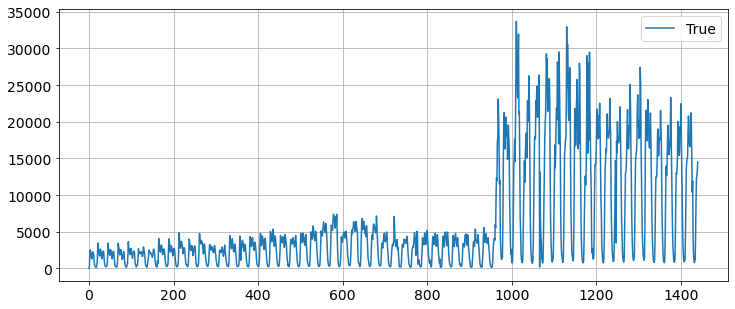

In [4]:
plt.figure(figsize=(12, 5))
plt.plot(Y, label='True')
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

# Preprocessing

In [5]:
# scaling
from sklearn.preprocessing import StandardScaler
Y = StandardScaler().fit_transform(Y)

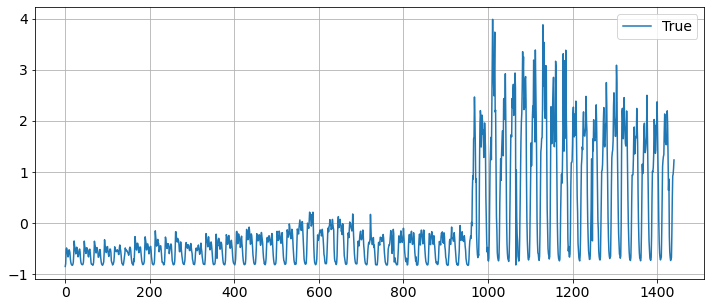

In [6]:
plt.figure(figsize=(12, 5))
plt.plot(Y, label='True')
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.show()

# Autoregressive Model for Time Series Forecast

Consider $y_1, y_2, ..., y_i, ..., y_N$ are observations of a time series. Autoregressive Model for the time series forecast assumes the following:

$$ \hat{y}_{i+m} = f( y_{i}, y_{i-1}, ... y_{i-k+1} ) $$

where $\hat{y}_{i+m}$ is a predicted value.

In matrix forms we will define this model as:

$$\hat{Y} = f(X)$$

where
$$X = \left(
\begin{array}{cccc}
y_{k} & y_{k-1} & \ldots & y_{1}\\
\vdots & \vdots & \ddots & \vdots\\
y_{k+j} & y_{k+j-1} & \ldots & y_{j+1}\\
\vdots & \vdots & \ddots & \vdots
\end{array}
\right)$$

$$Y = \left(
\begin{array}{c}
y_{k+m} \\
\vdots\\
y_{k+j+m}\\
\vdots
\end{array}
\right)$$

In [7]:
K = 20
M = 100

In [8]:
def AR_matrices(Y, K, M):
    X_AR = []
    Y_AR = []
    for i in range(len(Y)):
        
        if i < K-1: continue
        if i+M >= len(Y): break
        
        ax_ar = Y[i+1-K:i+1].reshape(-1, )
        X_AR.append(ax_ar)

        ay_ar = Y[i+M]#[0]
        Y_AR.append(ay_ar)

    return np.array(X_AR), np.array(Y_AR)

In [9]:
# prepare X and Y matrices
X_AR, Y_AR = AR_matrices(Y, K, M)

In [10]:
X_AR[:2]

array([[-0.85145517, -0.79876538, -0.51765743, -0.48937435, -0.51234538,
        -0.56230736, -0.66180063, -0.66223133, -0.59087758, -0.52497944,
        -0.5390492 , -0.57910493, -0.69597003, -0.7658881 , -0.80149319,
        -0.82001358, -0.82661775, -0.82905842, -0.81125588, -0.77335368],
       [-0.79876538, -0.51765743, -0.48937435, -0.51234538, -0.56230736,
        -0.66180063, -0.66223133, -0.59087758, -0.52497944, -0.5390492 ,
        -0.57910493, -0.69597003, -0.7658881 , -0.80149319, -0.82001358,
        -0.82661775, -0.82905842, -0.81125588, -0.77335368, -0.62375486]])

In [11]:
Y_AR[:2]

array([[-0.52943008],
       [-0.55713888]])

# Train / Test Split

In [12]:
N = 300
X_AR_train, X_AR_test = X_AR[:N], X_AR[N:]
Y_AR_train, Y_AR_test = Y_AR[:N], Y_AR[N:]

# Conditional GAN

<center><img src="img/cgan.png"></center>


Link: https://medium.com/@ma.bagheri/a-tutorial-on-conditional-generative-adversarial-nets-keras-implementation-694dcafa6282

# Conditional BiGAN

On this case we will use:
- $X$ - condition for Generator G, Encoder E and Discriminator D;
- $Y$ - values we want to generate with the Generator G.

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
class Generator(nn.Module):
    
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(n_inputs, 100)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.act2 = nn.ReLU()
        self.fc_out = nn.Linear(100, n_outputs)

    def forward(self, cond, z):
        x = torch.cat((cond, z), dim=1)
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc_out(x)
        return x


class Encoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(n_inputs, 100)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.act2 = nn.ReLU()
        self.fc_out = nn.Linear(100, n_outputs)

    def forward(self, cond, x):
        x = torch.cat((cond, x), dim=1)
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc_out(x)
        return x
    

class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(n_inputs, 100)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 100)
        self.act2 = nn.ReLU()
        self.fc_out = nn.Linear(100, 1)

    def forward(self, cond, x, z):
        xz = torch.cat((cond, x, z), dim=1)
        x = self.fc1(xz)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc_out(x)
        return x

In [15]:
class BiFitter(object):
    
    def __init__(self, generator, discriminator, encoder, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, n_critic=5):
        
        self.generator = generator
        self.discriminator = discriminator
        self.encoder = encoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        
        self.opt_gen  = torch.optim.RMSprop(list(self.generator.parameters()) + list(self.encoder.parameters()), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)
        
        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)
        self.encoder.to(DEVICE)
    
    
    def fit(self, X, Y):
        
        Cond = torch.tensor(X, dtype=torch.float, device=DEVICE)
        Y_real = torch.tensor(Y, dtype=torch.float, device=DEVICE)
        dataset_real = TensorDataset(Cond, Y_real)
        
        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)
        self.encoder.train(True)
        
        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (cond_batch, real_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                
                # generate a batch of fake objects
                z_batch = Variable(torch.tensor(np.random.normal(0, 1, (len(real_batch), self.latent_dim)), dtype=torch.float, device=DEVICE))
                fake_batch = self.generator(cond_batch, z_batch)
                
                # encode real objects back into latent space
                z_enc_batch = self.encoder(cond_batch, real_batch)
                
                ### Discriminator
                real_output = self.discriminator(cond_batch, real_batch, z_enc_batch)
                fake_output = self.discriminator(cond_batch, fake_batch, z_batch)
                
                ### Loss
                loss_disc = - torch.mean(real_output) + torch.mean(fake_output)
                
                self.opt_disc.zero_grad()
                loss_disc.backward(retain_graph=True)
                self.opt_disc.step()
                
                # Clip weights of discriminator
                for p in discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)
                    
                
                ### Train Generator
                
                if i % self.n_critic == 0:
                    
                    real_output = self.discriminator(cond_batch, real_batch, z_enc_batch)
                    fake_output = self.discriminator(cond_batch, fake_batch, z_batch)
                    
                    loss_gen = - torch.mean(fake_output) + torch.mean(real_output)

                    self.opt_gen.zero_grad()
                    loss_gen.backward()
                    self.opt_gen.step()
                    
            # caiculate and store loss after an epoch
            Z = Variable(torch.tensor(np.random.normal(0, 1, (len(Y_real), self.latent_dim)), dtype=torch.float, device=DEVICE))
            Y_fake = self.generator(Cond, Z)
            Z_enc = self.encoder(Cond, Y_real)
            real_output = self.discriminator(Cond, Y_real, Z_enc)
            fake_output = self.discriminator(Cond, Y_fake, Z)
            loss_epoch = torch.mean(real_output) - torch.mean(fake_output)
            self.loss_history.append(loss_epoch.detach().cpu())
                    
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)
        self.encoder.train(False)
        
        
    def generate(self, N):
        noise = Variable(torch.tensor(np.random.normal(0, 1, (N, self.latent_dim)), dtype=torch.float, device=DEVICE))
        # noise = Variable(torch.tensor(2*np.random.rand(N, self.latent_dim)-1, dtype=torch.float, device=DEVICE))
        X_gen = self.generator(noise)
        return X_gen
    
    def discriminate(self, X):
        intput = torch.tensor(X, dtype=torch.float, device=DEVICE)
        output = self.discriminator(intput).detach().numpy()
        return output

In [16]:
%%time
latent_dim = 1
generator     = Generator( X_AR.shape[1]+latent_dim, 1)
encoder       = Encoder(X_AR.shape[1]+1, latent_dim)
discriminator = Discriminator( X_AR.shape[1]+latent_dim+1)

fitter = BiFitter(generator, discriminator, encoder, batch_size=50, n_epochs=5000, latent_dim=latent_dim, lr=0.0001, n_critic=5)
fitter.fit(X_AR_train, Y_AR_train)

CPU times: user 3min 6s, sys: 2.17 s, total: 3min 8s
Wall time: 3min 10s


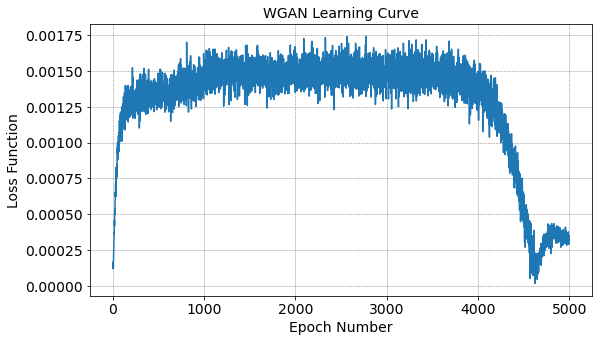

In [17]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

## Forecast Example

In [18]:
# define conditions
Cond_test = torch.tensor(X_AR_test, dtype=torch.float, device=DEVICE)

### Single Prediction

In [19]:
# generate noise in latent space
Z_test = torch.tensor(np.random.normal(0, 1, (len(Y_AR_test), latent_dim)), dtype=torch.float, device=DEVICE)
# make predictions using Generator G
Y_pred_test = fitter.generator(Cond_test, Z_test).cpu().detach().numpy()

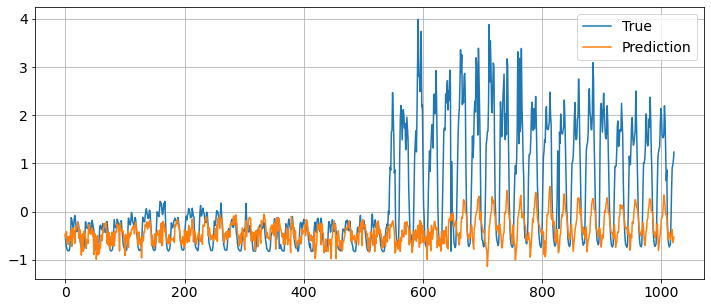

In [20]:
plt.figure(figsize=(12, 5))
plt.plot(Y_AR_test, label='True', alpha=1.)
plt.plot(Y_pred_test, label='Prediction', alpha=1.)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
#plt.xlim(300, 500)
plt.show()

### Multiple Predictions

In [21]:
predictions_test = []
for i in range(1000):
    # generate noise in latent space
    Z_test = torch.tensor(np.random.normal(0, 1, (len(Y_AR_test), latent_dim)), dtype=torch.float, device=DEVICE)
    # make predictions using Generator G
    Y_pred_test = fitter.generator(Cond_test, Z_test).cpu().detach().numpy()
    # store predictions
    predictions_test.append(Y_pred_test[:, 0])
predictions_test = np.array(predictions_test)

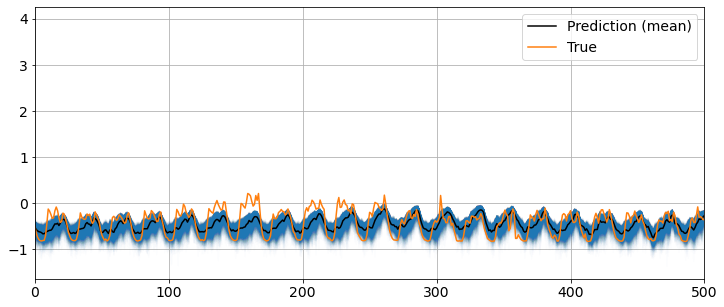

In [22]:
plt.figure(figsize=(12, 5))

for Y_pred_test in predictions_test:
    plt.plot(Y_pred_test, alpha=0.01, color='C0')
plt.plot(predictions_test.mean(axis=0), label='Prediction (mean)', alpha=1., color='0')

plt.plot(Y_AR_test, label='True', alpha=1., color='C1')
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
plt.xlim(0, 500)
#plt.ylim(0, 2)
plt.show()

# Change-Point Detection based on Prediction Errors

<center><img src="img/ts_anomaly.png"></center>


Link: https://towardsdatascience.com/anomaly-detection-time-series-4c661f6f165f

In [23]:
# estimate mean of multiple predictions
mean  = predictions_test.mean(axis=0)
# estimate standard deviation of multiple predictions
sigma = predictions_test.std(axis=0)

# calculate anomaly and change-point detection score
score = np.abs(Y_AR_test.reshape(-1, ) - mean) / sigma

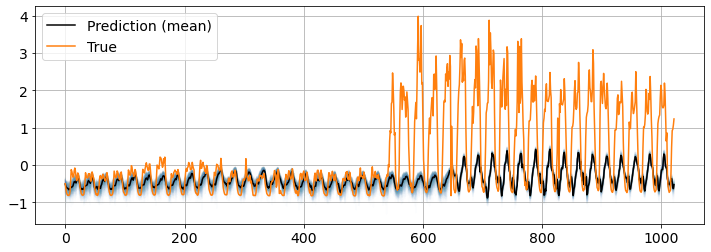

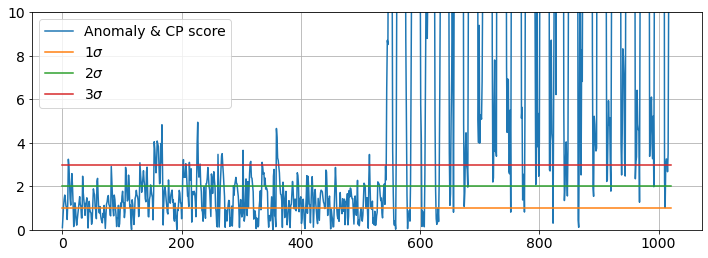

In [24]:
plt.figure(figsize=(12, 4))

for Y_pred_test in predictions_test[:100]:
    plt.plot(Y_pred_test, alpha=0.01, color='C0')
plt.plot(predictions_test.mean(axis=0), label='Prediction (mean)', alpha=1., color='0')

plt.plot(Y_AR_test, label='True', alpha=1., color='C1')
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
#plt.xlim(0, 500)
#plt.ylim(0, 2)
plt.show()


plt.figure(figsize=(12, 4))
plt.plot(score, label='Anomaly & CP score', alpha=1.)
plt.plot([1]*len(score), label=r'$1\sigma$', alpha=1.)
plt.plot([2]*len(score), label=r'$2\sigma$', alpha=1.)
plt.plot([3]*len(score), label=r'$3\sigma$', alpha=1.)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
#plt.xlim(0, 500)
plt.ylim(0, 10)
plt.show()

# Change-Point Detection based on BiGAN Reconstruction Errors

BiGAN helps to detect anomalies by estimating the following score function $A(x)$:

$$A(x) = \alpha L_{G}(x) + (1 - \alpha)L_{D}(x),$$

where

$$L_{G}(x) = || x - G(E(x)) ||_{1},$$

$$L_{D}(x) = || D(x, E(x)) - D(G(E(x)), E(x)) ||_{1},$$

$\alpha$ is an adjustable parameter.

In [25]:
Cond_test = torch.tensor(X_AR_test, dtype=torch.float, device=DEVICE)
Y_real_test = torch.tensor(Y_AR_test, dtype=torch.float, device=DEVICE)

Z_enc_test = fitter.encoder(Cond_test, Y_real_test)
Y_enc_pred_test = fitter.generator(Cond_test, Z_enc_test)

real_output = fitter.discriminator(Cond_test, Y_real_test, Z_enc_test).cpu().detach().numpy()
pred_output = fitter.discriminator(Cond_test, Y_enc_pred_test, Z_enc_test).cpu().detach().numpy()

Y_enc_pred_test = Y_enc_pred_test.cpu().detach().numpy()
Z_enc_test = Z_enc_test.cpu().detach().numpy()

In [26]:
# calculate anomaly score A(x)
alpha = 0.9
L_G = np.abs(Y_AR_test - Y_enc_pred_test).sum(axis=1)
L_D = np.abs(real_output - pred_output).sum(axis=1)

A = alpha * L_G + (1 - alpha) * L_D

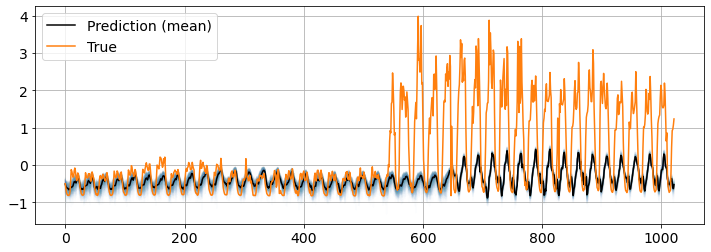

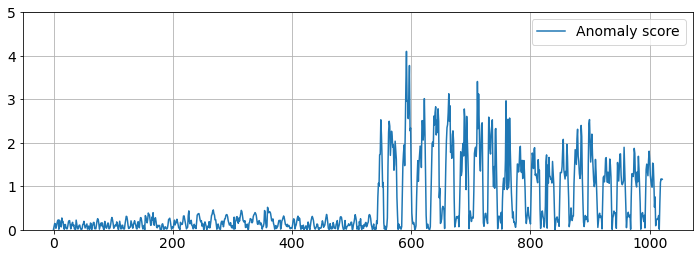

In [27]:
plt.figure(figsize=(12, 4))

for Y_pred_test in predictions_test[:100]:
    plt.plot(Y_pred_test, alpha=0.01, color='C0')
plt.plot(predictions_test.mean(axis=0), label='Prediction (mean)', alpha=1., color='0')

plt.plot(Y_AR_test, label='True', alpha=1., color='C1')
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
#plt.xlim(0, 500)
#plt.ylim(0, 2)
plt.show()


plt.figure(figsize=(12, 4))
plt.plot(A, label='Anomaly score', alpha=1.)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc='best', fontsize=14)
plt.grid(b=1)
#plt.xlim(0, 500)
plt.ylim(0, 5)
plt.show()